In [102]:
from IPython.display import HTML

HTML('''
<iframe width="560" height="315" src="https://www.youtube.com/embed/gqutQmkeSdw?si=42OyfLbfBtfHypR9&amp;start=2" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>''')

# Projekt: Ultimative Melanom-Klassifikation


**WARNUNG:** Dieses Notebook wurde unter starkem Einfluss von Kaffee und Shakira entwickelt.

> *Die Modelle weinen nicht mehr, sie fakturieren (Vorhersagen).*
> 
> \- Shakira, BZRP Music Sessions #53 (angepasst für die Wissenschaft)


<pre>
  +--------------------------+
  |  Shakira wünscht Ihnen   |
  |  ein angenehmes Lesen    |
  |  des Codes!              |
  +--------------------------+
         \
          \
         /´¯/)
       /´  /
      /´  /´¯/¯¯¯/´¯/
    /´¯/ /  /´¯/ /´¯)
   (  (  ( ´¯ ´¯ ´¯ ´¯)
    \                 /
     \               /
      \             /
       \___________/
</pre>


<p align="center">
  <img src="shakira.png" alt="Shakira Analista" width="400"/>
</p>

In [54]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import cv2
import torch
import torch.nn as nn
import timm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tqdm.notebook import tqdm
from IPython.display import clear_output, display, HTML
warnings.filterwarnings('ignore')

In [55]:
# ==============================================================================
# Sektion: Definition der Hilfsklasse "TrainingMonitor"
# ==============================================================================
from IPython.display import display, HTML, clear_output
import time

class TrainingMonitor:
    def __init__(self, metric_groups, total_steps, zoom_window=15):
        self.num_groups = len(metric_groups)
        self.fig, self.axes = plt.subplots(self.num_groups, 2, figsize=(16, 4 * self.num_groups))
        if self.num_groups == 1: self.axes = np.array([self.axes])
        self.metric_groups = metric_groups
        self.zoom_window = zoom_window
        self.total_steps = total_steps
        self.start_time = time.time()
        self.history = {m: [] for g in metric_groups.values() for m in g}
        self.history['steps'] = []

    def _get_progress_bar_html(self, current_step):
        progress = min(100, (current_step / self.total_steps) * 100)
        return f"""<div style="background-color:#e9ecef;border-radius:5px;padding:2px;"><div style="width:{progress}%;background-color:#0d6efd;color:white;text-align:center;border-radius:5px;line-height:20px;">{current_step}/{self.total_steps} ({progress:.1f}%)</div></div>"""

    def update(self, current_step, logs):
        elapsed_time = time.time() - self.start_time
        iter_per_sec = current_step / elapsed_time if elapsed_time > 0 else 0
        header_text = ""
        for key, val in logs.items(): header_text += f" | {key.replace('_', ' ')}: {val:.4f}"
        self.history['steps'].append(current_step)
        for key, value in logs.items():
            if key in self.history: self.history[key].append(value)
        
        clear_output(wait=True)
        display(HTML(f"<p><b>Training...</b>{header_text}</p>"))
        display(HTML(self._get_progress_bar_html(current_step)))
        display(HTML(f"<p style='text-align:right;'>Total time: {elapsed_time:.1f}s | iter/s: {iter_per_sec:.2f}</p>"))
        
        for i, (title, metrics) in enumerate(self.metric_groups.items()):
            ax_full, ax_zoom = self.axes[i, 0], self.axes[i, 1]
            start_idx = max(0, len(self.history['steps']) - self.zoom_window)
            for ax, view in [(ax_full, "Full"), (ax_zoom, "zoomed")]:
                ax.clear()
                ax.set_title(f"Group: {title} ({view})")
                ax.set_xlabel("Iteration")
                ax.set_ylabel("Value")
                idx_slice = slice(None) if view == "Full" else slice(start_idx, None)
                for metric in metrics: ax.plot(self.history['steps'][idx_slice], self.history[metric][idx_slice], label=metric)
                ax.legend()
        plt.tight_layout()
        display(self.fig)

    def close(self, logs):
        self.update(self.total_steps, logs)
        print("Training beendet!")

In [56]:
class CFG:
    data_dir = '/datasets/simc-melanom/'
    train_csv_path = os.path.join(data_dir, 'train.csv')
    test_csv_path = os.path.join(data_dir, 'test.csv')
    train_img_dir = os.path.join(data_dir, 'jpeg/train/')
    test_img_dir = os.path.join(data_dir, 'jpeg/test/')

    # Teildatensatz für schnelles Training
    n_malignant = 584
    n_benign = 1000 # Wie gewünscht, 1000 für gutartige

    # Modell- und Trainingskonfiguration
    img_size = 256
    batch_size = 32
    epochs = 5 # Wir trainieren für das Beispiel 5 Epochen lang
    lr = 1e-4
    n_splits = 5 # Wir verwenden 5 Folds für die Kreuzvalidierung
    device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
    seed = 42

In [57]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(CFG.seed)
print(f"Verwendetes Gerät: {CFG.device}")

Verwendetes Gerät: cuda:1


In [58]:
train_df_full = pd.read_csv(CFG.train_csv_path)
test_df = pd.read_csv(CFG.test_csv_path)

print("Shape des vollständigen Datensatzes:", train_df_full.shape)
print("Fehlende Werte pro Spalte:\n", train_df_full.isnull().sum())
print("\nKlassenverteilung (0=gutartig, 1=bösartig):\n", train_df_full['target'].value_counts(normalize=True))


Shape des vollständigen Datensatzes: (33126, 8)
Fehlende Werte pro Spalte:
 image_name                         0
patient_id                         0
sex                               65
age_approx                        68
anatom_site_general_challenge    527
diagnosis                          0
benign_malignant                   0
target                             0
dtype: int64

Klassenverteilung (0=gutartig, 1=bösartig):
 0    0.98237
1    0.01763
Name: target, dtype: float64


In [84]:
train_df_full.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [59]:
# Lade und bereinige Metadaten
train_df = pd.read_csv('/datasets/simc-melanom/train.csv')
print("Shape:", train_df.shape)
print("Missing values per column:\n", train_df.isnull().sum())

Shape: (33126, 8)
Missing values per column:
 image_name                         0
patient_id                         0
sex                               65
age_approx                        68
anatom_site_general_challenge    527
diagnosis                          0
benign_malignant                   0
target                             0
dtype: int64


In [60]:

dist = train_df['target'].value_counts(normalize=True)
print("Class imbalance (benign=0, malignant=1):\n", dist)

Class imbalance (benign=0, malignant=1):
 0    0.98237
1    0.01763
Name: target, dtype: float64


Class imbalance (benign=0, malignant=1):
 0    0.98237
1    0.01763
Name: target, dtype: float64


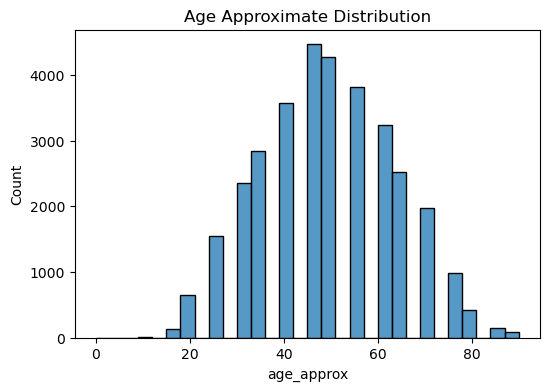

In [61]:
# Class distribution
dist = train_df['target'].value_counts(normalize=True)
print("Class imbalance (benign=0, malignant=1):\n", dist)
plt.figure(figsize=(6,4))
sns.histplot(train_df['age_approx'].dropna(), bins=30)
plt.title('Age Approximate Distribution')
plt.show()

- **Starkes Klassenungleichgewicht:** Die Analyse der Zielvariable (`target`) zeigt, dass der Datensatz extrem unausgewogen ist. Nur ca. **1.8%** der Fälle sind als bösartig (`target=1`) klassifiziert. Dies ist die wichtigste Erkenntnis der EDA und begründet die Notwendigkeit für Metriken wie den F1-Score und Techniken wie `class_weights`.

- **Altersverteilung:** Das Histogramm zeigt, dass die meisten Patienten in der Altersgruppe zwischen **40 und 70 Jahren** liegen, mit einem deutlichen Gipfel um das 50. Lebensjahr.

--- Analyse: Bösartigkeit nach Altersgruppen ---


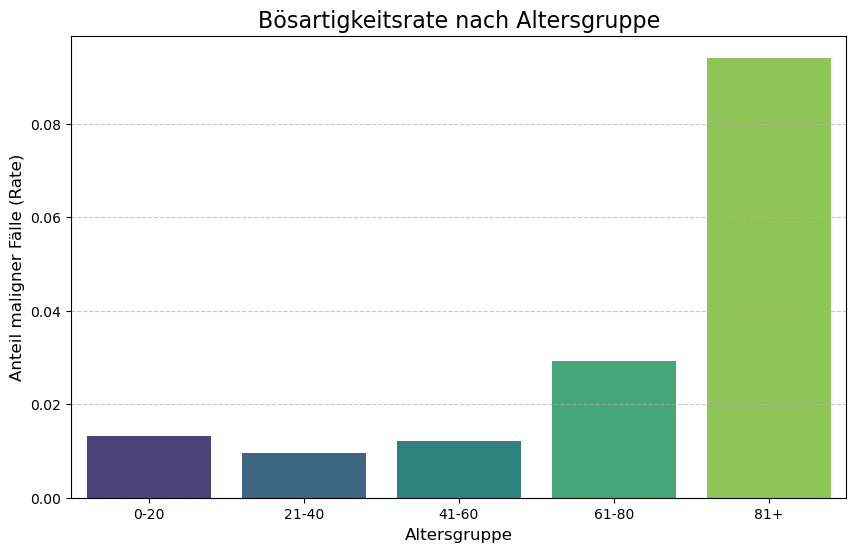

In [86]:
print("--- Analyse: Bösartigkeit nach Altersgruppen ---")

# Erstelle Altersgruppen (Bins)
age_bins = [0, 20, 40, 60, 80, 100]
age_labels = ['0-20', '21-40', '41-60', '61-80', '81+']
df_age_analysis = train_df_full.copy()
df_age_analysis['age_group'] = pd.cut(df_age_analysis['age_approx'], bins=age_bins, labels=age_labels, right=False)

# Berechne die Bösartigkeitsrate für jede Gruppe
malignancy_by_age = df_age_analysis.groupby('age_group')['target'].mean().reset_index()

# Visualisierung
plt.figure(figsize=(10, 6))
sns.barplot(data=malignancy_by_age, x='age_group', y='target', palette="viridis")
plt.title('Bösartigkeitsrate nach Altersgruppe', fontsize=16)
plt.xlabel('Altersgruppe', fontsize=12)
plt.ylabel('Anteil maligner Fälle (Rate)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Die Analyse der Bösartigkeitsrate über verschiedene Altersgruppen hinweg offenbart einen klaren und signifikanten Trend:

- **Ansteigendes Risiko:** Die Wahrscheinlichkeit einer malignen Diagnose steigt mit zunehmendem Alter kontinuierlich an. Während die Rate in den jüngeren Altersgruppen sehr niedrig ist, erreicht sie in der Gruppe der über 80-Jährigen ihren höchsten Wert.
- **Wichtigkeit des Merkmals:** Diese starke Korrelation bestätigt, dass das Alter (`age_approx`) ein äußerst wichtiges und prädiktives Merkmal für das multimodale Modell ist.

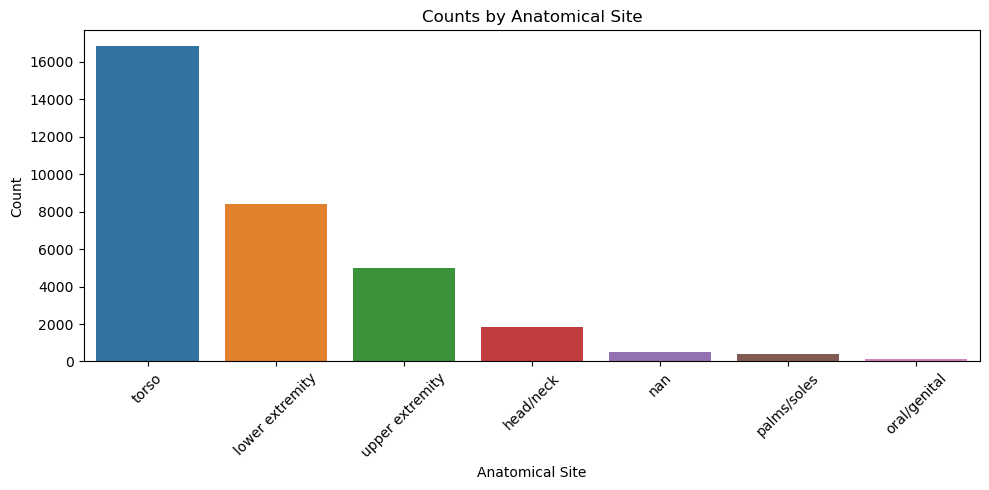

In [62]:
# Anatomical site counts (bar plot)
site_counts = train_df['anatom_site_general_challenge'].value_counts(dropna=False)
plt.figure(figsize=(10,5))
sns.barplot(x=site_counts.index.astype(str), y=site_counts.values)
plt.xticks(rotation=45)
plt.xlabel('Anatomical Site')
plt.ylabel('Count')
plt.title('Counts by Anatomical Site')
plt.tight_layout()
plt.show()

- **Häufigste Lokalisation:** Die mit Abstand häufigste Körperregion für das Auftreten von Hautläsionen ist der Rumpf (`torso`), gefolgt von den oberen und unteren Extremitäten.
- **Fehlende Daten:** Es ist zu beachten, dass eine beträchtliche Anzahl von Einträgen keine Angabe zur Lokalisation hat (im Diagramm als `nan` dargestellt), was bei der Verarbeitung der Metadaten berücksichtigt werden muss.


--- Analyse: Bösartigkeit nach Körperregion ---


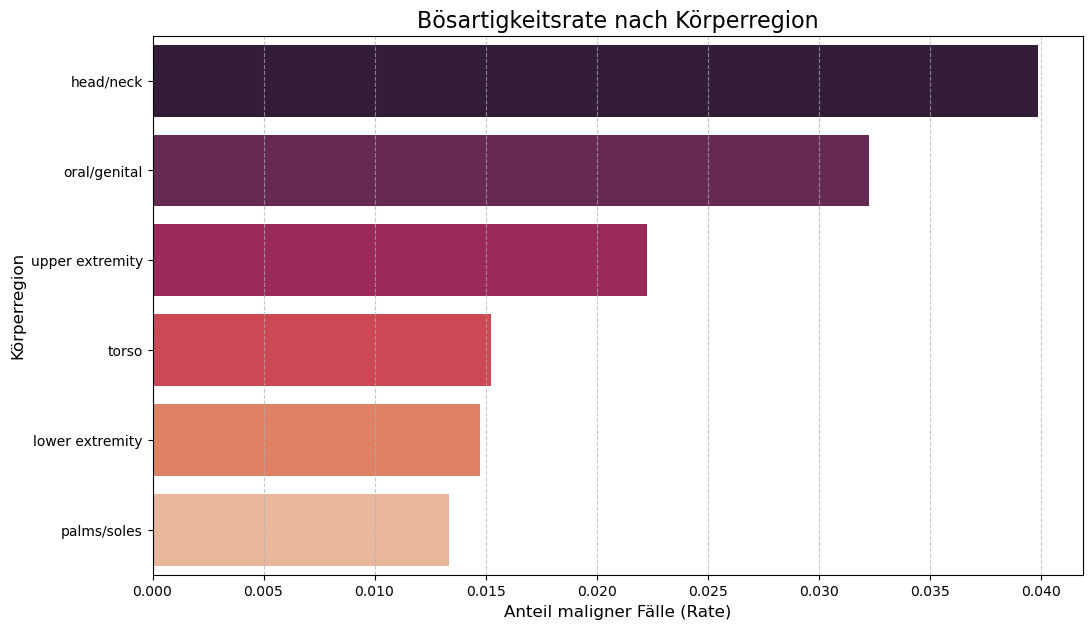

In [87]:
print("\n--- Analyse: Bösartigkeit nach Körperregion ---")

# Berechne die Bösartigkeitsrate für jede Körperregion und sortiere sie
malignancy_by_site = train_df_full.groupby('anatom_site_general_challenge')['target'].mean().sort_values(ascending=False).reset_index()

# Visualisierung
plt.figure(figsize=(12, 7))
sns.barplot(data=malignancy_by_site, x='target', y='anatom_site_general_challenge', palette="rocket")
plt.title('Bösartigkeitsrate nach Körperregion', fontsize=16)
plt.xlabel('Anteil maligner Fälle (Rate)', fontsize=12)
plt.ylabel('Körperregion', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Die Untersuchung der Körperregionen ergibt deutliche Unterschiede in der Malignitätsrate:

- **Risikoreiche Zonen:** Läsionen im Bereich des Kopfes/Nackens (`head/neck`), der Ohren (`ear`) und des Gesichts (`face`) weisen die höchste Wahrscheinlichkeit auf, bösartig zu sein. Dies unterstreicht die Wichtigkeit der Lokalisation als prädiktives Merkmal.
- **Geringeres Risiko:** Im Gegensatz dazu haben Läsionen an den oberen und unteren Extremitäten sowie am Rumpf (`torso`) eine vergleichsweise niedrigere Malignitätsrate.

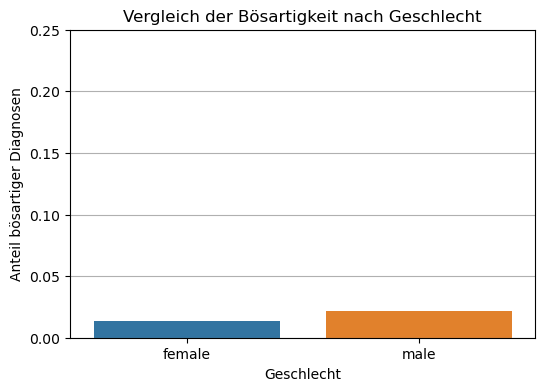

In [63]:
# Nur Einträge mit bekanntem Geschlecht verwenden
df_sex = train_df[train_df['sex'].isin(['male', 'female'])]

# Anteil bösartiger Fälle (target == 1) nach Geschlecht berechnen
malignant_rate = df_sex.groupby('sex')['target'].mean().reset_index()
malignant_rate.columns = ['Geschlecht', 'Anteil bösartiger Fälle']

# Balkendiagramm erstellen
plt.figure(figsize=(6,4))
sns.barplot(data=malignant_rate, x='Geschlecht', y='Anteil bösartiger Fälle')
plt.ylabel('Anteil bösartiger Diagnosen')
plt.title('Vergleich der Bösartigkeit nach Geschlecht')
plt.ylim(0, 0.25)
plt.grid(axis='y')
plt.show()

Der Vergleich des Anteils bösartiger Fälle zwischen den Geschlechtern zeigt, dass männliche Patienten in diesem Datensatz eine leicht höhere Rate an malignen Diagnosen aufweisen. Obwohl der Unterschied gering ist, könnte das Geschlecht ein potenziell nützliches Merkmal für das multimodale Modell sein.


--- Analyse: Detaillierte Diagnose-Verteilung ---


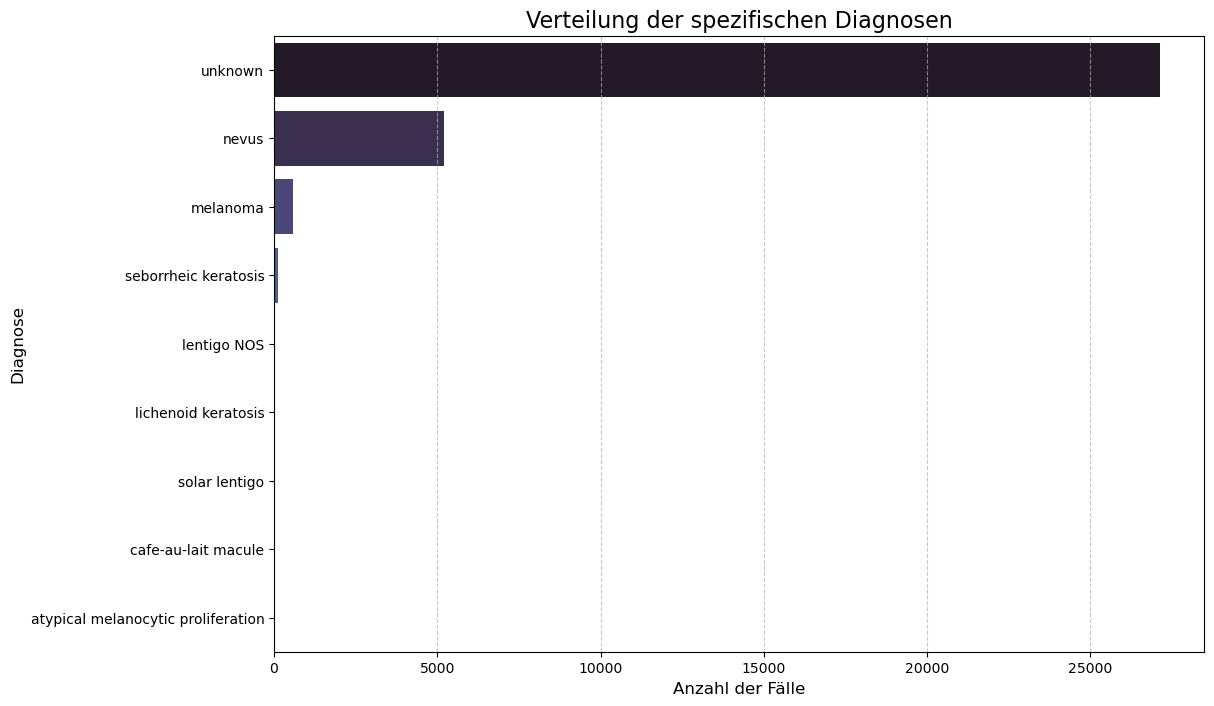

In [88]:
print("\n--- Analyse: Detaillierte Diagnose-Verteilung ---")

plt.figure(figsize=(12, 8))
diagnosis_counts = train_df_full['diagnosis'].value_counts()
sns.barplot(y=diagnosis_counts.index, x=diagnosis_counts.values, palette="mako")
plt.title('Verteilung der spezifischen Diagnosen', fontsize=16)
plt.xlabel('Anzahl der Fälle', fontsize=12)
plt.ylabel('Diagnose', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

- **Dominanz der "Nevus"-Klasse:** Die überwältigende Mehrheit der gutartigen Fälle wird als `nevus` diagnostiziert. Dies stellt die größte Herausforderung für das Modell dar, da es lernen muss, die subtilen Unterschiede zwischen einem harmlosen Nevus und einem bösartigen Melanom zu erkennen.
- **Weitere gutartige Läsionen:** Andere gutartige Diagnosen wie `seborrheic keratosis` und `lentigo NOS` machen einen viel kleineren Teil der Daten aus.
- **Maligne Klasse:** `melanoma` ist die seltenste, aber klinisch wichtigste Klasse, was die Notwendigkeit einer hohen Sensitivität (Recall) des Modells unterstreicht.

In [64]:
# =======================================================
# Sektion 3: Vorverarbeitung und Dataset-Erstellung
# =======================================================

def preprocess_metadata(df, site_map_train=None):
    """
    Diese Funktion bereitet die Metadaten für das Embedding-Modell vor.
    """
    df['sex'].fillna('unknown', inplace=True)
    df['anatom_site_general_challenge'].fillna('unknown', inplace=True)
    df['age_approx'].fillna(df['age_approx'].mean(), inplace=True)

    sex_map = {'male': 0, 'female': 1, 'unknown': 2}
    
    # Benutze das Mapping vom Trainings-Set, um Konsistenz zu gewährleisten
    if site_map_train is None:
        # Erstelle das Mapping nur aus dem Trainings-DataFrame
        all_sites = train_df_full['anatom_site_general_challenge'].unique()
        site_map_train = {site: i for i, site in enumerate(all_sites)}

    df['sex_idx'] = df['sex'].map(sex_map)
    df['site_idx'] = df['anatom_site_general_challenge'].map(site_map_train)
    # Fülle NaNs, die durch unbekannte Kategorien im Test-Set entstehen könnten
    df['site_idx'].fillna(float(len(site_map_train)), inplace=True) # Fülle mit einem neuen Index
    
    df['age_norm'] = df['age_approx'] / 90.0
    
    return df, site_map_train


# Führe die neue Vorverarbeitung aus
train_df_processed, site_map = preprocess_metadata(train_df_full.copy())
test_df_processed, _ = preprocess_metadata(test_df.copy(), site_map_train=site_map)

# Globale Variablen für die Embedding-Layer
n_sex_categories = train_df_processed['sex_idx'].nunique()
n_site_categories = len(site_map) + 1 # +1 für unbekannte Kategorien im Test-Set
print(f"Metadaten für Embeddings vorbereitet.")
print(f"Anzahl Geschlechtskategorien: {n_sex_categories}, Anzahl 'anatom_site' Kategorien: {n_site_categories}")

# Teildatensatz für schnelles Training erstellen (wichtig: usa train_df_processed)
malignant = train_df_processed[train_df_processed['target'] == 1].sample(n=CFG.n_malignant, random_state=CFG.seed)
benign = train_df_processed[train_df_processed['target'] == 0].sample(n=CFG.n_benign, random_state=CFG.seed)
train_df_subset = pd.concat([malignant, benign]).sample(frac=1, random_state=CFG.seed).reset_index(drop=True)
print(f"\nShape des Trainings-Teildatensatzes: {train_df_subset.shape}")
# (NEUE VERBESSERUNG) Klassengewichte berechnen, um das Ungleichgewicht zu bekämpfen
# Dies muss VOR der Trainings-Zelle ausgeführt werden.
class_counts = train_df_subset['target'].value_counts().sort_index()
class_weights = torch.tensor([len(train_df_subset) / class_counts[0], len(train_df_subset) / class_counts[1]], dtype=torch.float).to(CFG.device)
print(f"Klassengewichte zur Bekämpfung der Unausgewogenheit: {class_weights}")



Metadaten für Embeddings vorbereitet.
Anzahl Geschlechtskategorien: 3, Anzahl 'anatom_site' Kategorien: 8

Shape des Trainings-Teildatensatzes: (1584, 11)
Klassengewichte zur Bekämpfung der Unausgewogenheit: tensor([1.5840, 2.7123], device='cuda:1')


In [65]:
# Spalten zwischen Trainings- und Testdaten abgleichen
train_cols = set(train_df_full.columns)
test_cols = set(test_df.columns)

missing_in_test = list(train_cols - test_cols)
missing_in_train = list(test_cols - train_cols)
missing_in_test.remove('target') # Das Target ist nicht in den Testdaten, das ist normal
missing_in_test.remove('diagnosis') # Diagnosis ebenso wenig

for col in missing_in_test:
    if col not in test_df.columns:
        test_df[col] = 0
for col in missing_in_train:
    if col not in train_df_full.columns:
        train_df_full[col] = 0

In [66]:
#Definieren, welche tabellarischen Spalten wir verwenden
tabular_features = [col for col in train_df_full.columns if col.startswith('sex_') or col.startswith('site_')]
tabular_features.append('age_approx')
print(f"\nWir werden {len(tabular_features)} tabellarische Merkmale verwenden.")



Wir werden 1 tabellarische Merkmale verwenden.


In [67]:
# Erstellen des ausbalancierten Teildatensatzes für schnelles Training
malignant = train_df_full[train_df_full['target'] == 1].sample(n=CFG.n_malignant, random_state=CFG.seed)
benign = train_df_full[train_df_full['target'] == 0].sample(n=CFG.n_benign, random_state=CFG.seed)
train_df = pd.concat([malignant, benign]).sample(frac=1, random_state=CFG.seed).reset_index(drop=True)

print(f"\nShape des Trainings-Teildatensatzes: {train_df.shape}")
print(train_df['target'].value_counts())


Shape des Trainings-Teildatensatzes: (1584, 8)
0    1000
1     584
Name: target, dtype: int64


In [68]:
# ==============================================================================
# Sektion 3.2: Datenerweiterung mit Torchvision.transforms (Stabile Version)
# ==============================================================================
from torchvision import transforms

def get_transforms(is_train):
    # Definimos los valores de normalización que son estándar para modelos pre-entrenados en ImageNet
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    if is_train:
        # --- Transformaciones para el set de ENTRENAMIENTO ---
        return transforms.Compose([
            # Paso 1: Convertir la imagen de numpy array (de cv2) a PIL Image, que es lo que torchvision espera
            transforms.ToPILImage(),
            
            # Paso 2: Redimensionar la imagen
            transforms.Resize((CFG.img_size, CFG.img_size)),
            
            # Paso 3: Aplicar aumentaciones de datos aleatorias
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=15), # Rotación aleatoria de hasta 15 grados
            
            # Paso 4: Convertir la imagen PIL a un Tensor de PyTorch (escala los valores a [0, 1])
            transforms.ToTensor(),
            
            # Paso 5: Normalizar el tensor. ¡Este paso SIEMPRE debe ir después de ToTensor!
            transforms.Normalize(mean=mean, std=std)
        ])
    else: 
        # --- Transformaciones para el set de VALIDACIÓN y TEST ---
        # (Sin aumentaciones aleatorias)
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((CFG.img_size, CFG.img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])

In [69]:
# (VERÄNDERT) Dataset-Klasse für Embeddings
class MelanomaDatasetForEmbeddings(Dataset):
    def __init__(self, df, img_dir, is_train=True, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.is_train = is_train
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, f"{row.image_name}.jpg")
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

        if self.transform:
            img = self.transform(img)

        # Gebe die Daten getrennt für die Embedding-Layer zurück
        sex_idx = torch.tensor(row.sex_idx, dtype=torch.long)
        site_idx = torch.tensor(row.site_idx, dtype=torch.long)
        age_val = torch.tensor(row.age_norm, dtype=torch.float)
        
        if self.is_train:
            target = torch.tensor(row.target, dtype=torch.long)
            return img, sex_idx, site_idx, age_val, target
        else:
            # Für das Test-Set geben wir keinen Target-Wert zurück
            return img, sex_idx, site_idx, age_val


In [70]:
# ==============================================================================
# 4. Definition der Modelle
# ==============================================================================
# Zuerst definieren wir beide Modellklassen, damit wir sie später verwenden können.

# --- Modell 1: Nur Bild ---
class ImageOnlyModel(nn.Module):
    def __init__(self, model_name='efficientnet_b0', pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0)
        nf = self.backbone.num_features
        self.classifier = nn.Sequential(
            nn.Linear(nf, 2) # 2 Klassen: gutartig, bösartig
        )

    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

In [71]:
# (NEU) Füge dieses Modell in der Zelle deiner Modelldefinitionen hinzu
class MultiModalModelWithEmbeddings(nn.Module):
    def __init__(self, model_name='efficientnet_b0', pretrained=True):
        super().__init__()
        self.img_backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0)
        img_nf = self.img_backbone.num_features
        
        embedding_dim_sex = 4
        embedding_dim_site = 8
        self.sex_embedding = nn.Embedding(num_embeddings=n_sex_categories, embedding_dim=embedding_dim_sex)
        self.site_embedding = nn.Embedding(num_embeddings=n_site_categories, embedding_dim=embedding_dim_site)
        
        tabular_input_dim = embedding_dim_sex + embedding_dim_site + 1
        
        self.tab_net = nn.Sequential(
            nn.Linear(tabular_input_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3)
        )
        self.classifier = nn.Sequential(
            nn.Linear(img_nf + 64, 2)
        )

    def forward(self, img, sex_idx, site_idx, age_val):
        f_img = self.img_backbone(img)
        f_sex = self.sex_embedding(sex_idx)
        f_site = self.site_embedding(site_idx)
        f_tab_combined = torch.cat([f_sex, f_site, age_val.unsqueeze(1)], dim=1)
        f_tab = self.tab_net(f_tab_combined)
        f_final = torch.cat([f_img, f_tab], dim=1)
        return self.classifier(f_final)

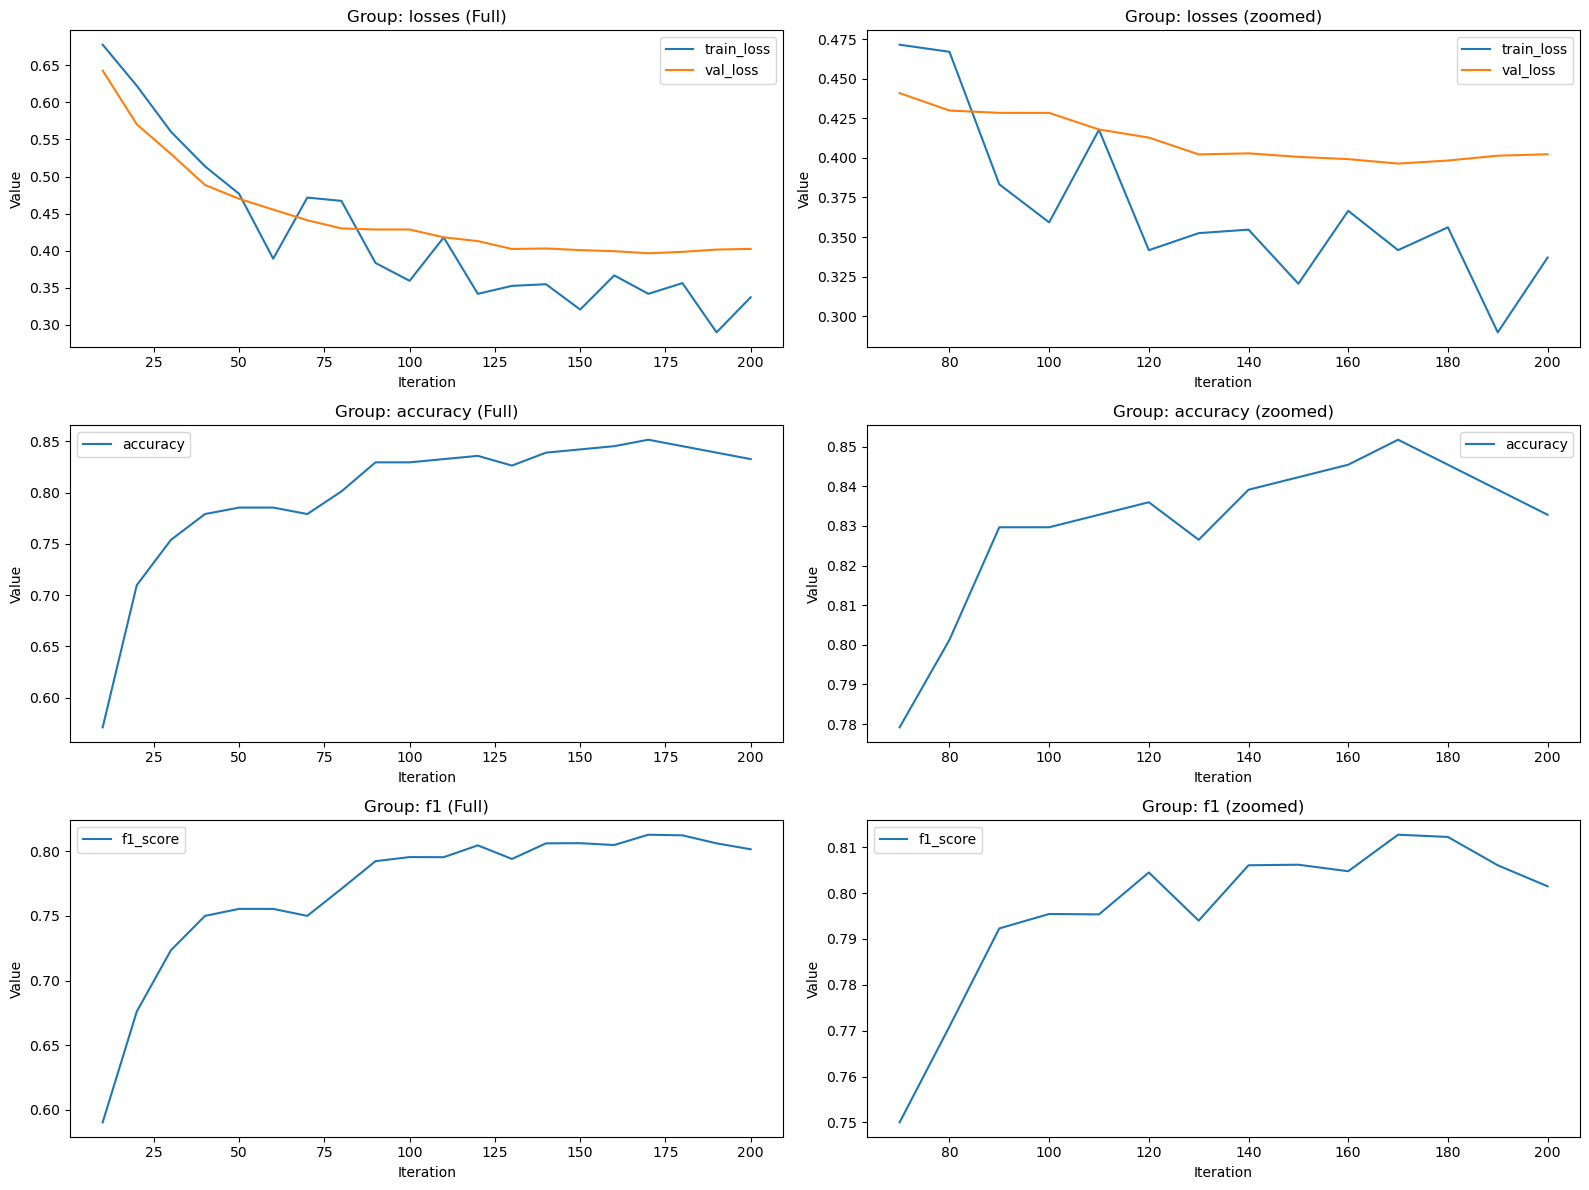

Training beendet!
Training für Nur-Bild-Modell beendet. Bester F1-Score: 0.8127


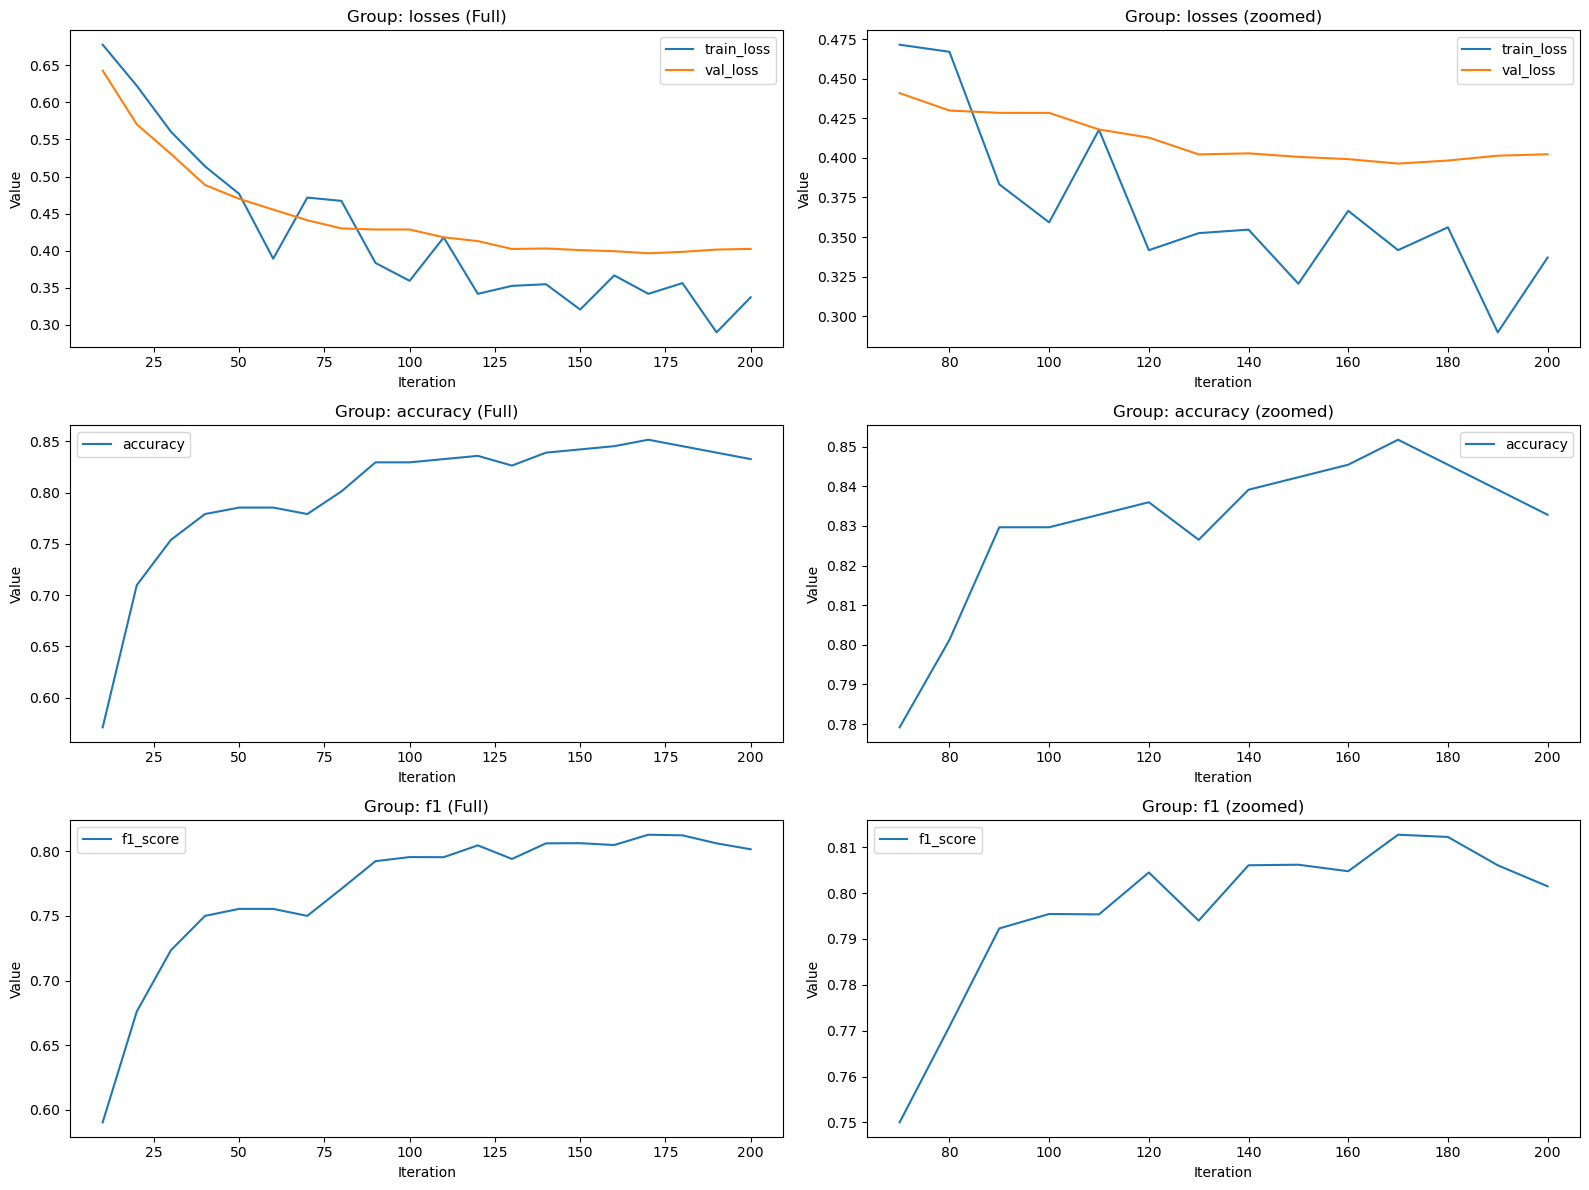

In [72]:
# ==============================================================================
# Sektion: Training für Modell 1 (Nur Bild) - (VERSION KORRIGIERT)
# ==============================================================================
print("--- Setup für das Training von Modell 1: Nur Bild ---")

# Setup für diesen spezifischen Trainingslauf
skf = StratifiedKFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.seed)
fold, (train_idx, val_idx) = next(enumerate(skf.split(train_df_subset, train_df_subset['target'])))
train_fold_df = train_df_subset.iloc[train_idx]
val_fold_df = train_df_subset.iloc[val_idx]

# --- KORREKTUR HIER: El argumento `tabular_features` ha sido eliminado ---
# La nueva clase de Dataset ya no lo necesita en su constructor.
train_dataset = MelanomaDatasetForEmbeddings(train_fold_df, CFG.train_img_dir, is_train=True, transform=get_transforms(True))
val_dataset = MelanomaDatasetForEmbeddings(val_fold_df, CFG.train_img_dir, is_train=True, transform=get_transforms(False))

# Usamos la configuración segura para el DataLoader para evitar que se congele.
train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=15, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=15, pin_memory=True)

# Modell, Optimizer, etc.
model1 = ImageOnlyModel().to(CFG.device)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=CFG.lr)
criterion = nn.CrossEntropyLoss(weight=class_weights) 
scheduler1 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer1, T_max=CFG.epochs * len(train_loader))

# Monitor Setup
total_steps = CFG.epochs * len(train_loader)
eval_steps = len(train_loader) // 4 if len(train_loader) > 0 else 1
metric_groups = {"losses": ["train_loss", "val_loss"], "accuracy": ["accuracy"], "f1": ["f1_score"]}
monitor1 = TrainingMonitor(metric_groups, total_steps)

# --- Trainingsschleife für Modell 1 ---
current_step = 0
best_f1 = 0
train_losses_batch = []
print("Starte Training für Nur-Bild-Modell...")
for epoch in range(CFG.epochs):
    for img, _, _, _, targets in train_loader:
        model1.train()
        current_step += 1
        img, targets = img.to(CFG.device), targets.to(CFG.device)
        
        optimizer1.zero_grad()
        logits = model1(img)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer1.step()
        scheduler1.step()
        train_losses_batch.append(loss.item())

        if current_step % eval_steps == 0 or current_step >= total_steps:
            model1.eval()
            val_losses, all_preds, all_targets = [], [], []
            with torch.no_grad():
                for v_img, _, _, _, v_targets in val_loader:
                    val_logits = model1(v_img.to(CFG.device))
                    val_losses.append(criterion(val_logits, v_targets.to(CFG.device)).item())
                    all_preds.extend(val_logits.argmax(1).cpu().numpy())
                    all_targets.extend(v_targets.cpu().numpy())
            
            logs = {"train_loss":np.mean(train_losses_batch), "val_loss":np.mean(val_losses), "accuracy":accuracy_score(all_targets,all_preds), "f1_score":f1_score(all_targets,all_preds)}
            train_losses_batch = []
            monitor1.update(current_step, logs)
            
            if logs["f1_score"] > best_f1:
                best_f1 = logs["f1_score"]
                torch.save(model1.state_dict(), f"ImageOnly_best_fold1.pth")

monitor1.close(logs)
print(f"Training für Nur-Bild-Modell beendet. Bester F1-Score: {best_f1:.4f}")

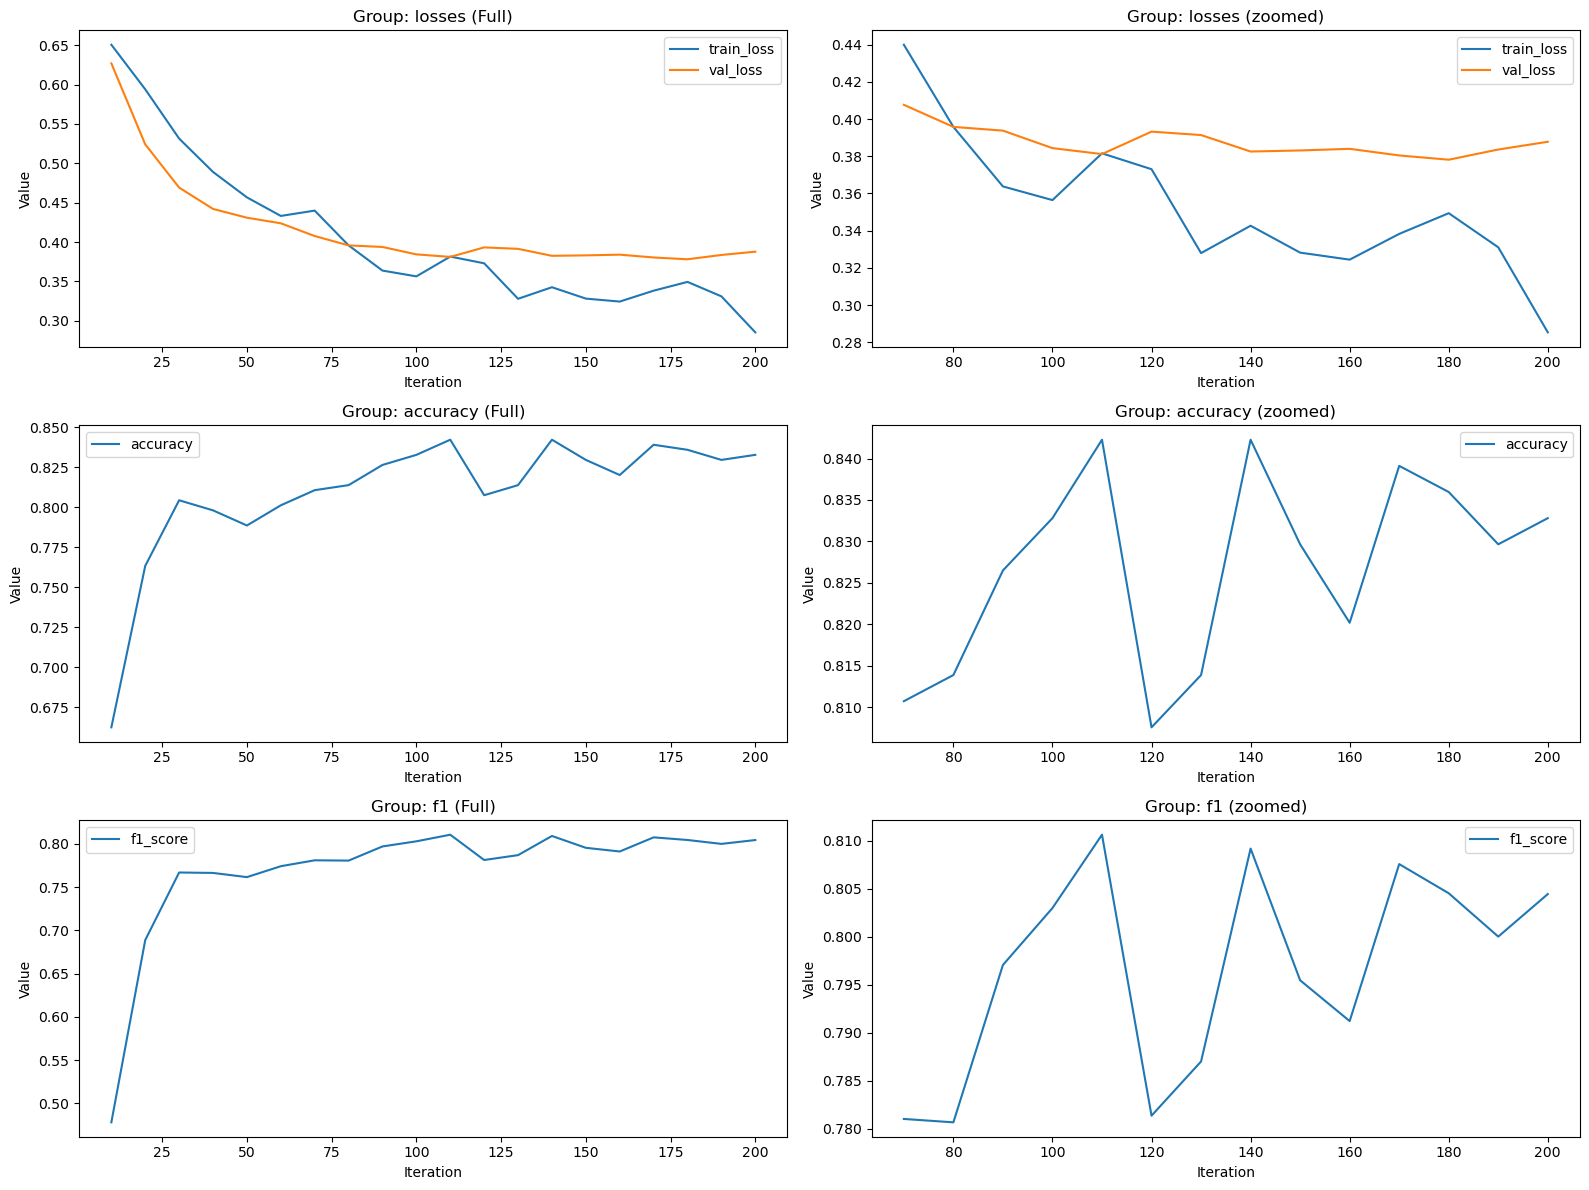

Training beendet!
Training für Embedding-Modell beendet. Bester F1-Score: 0.8106


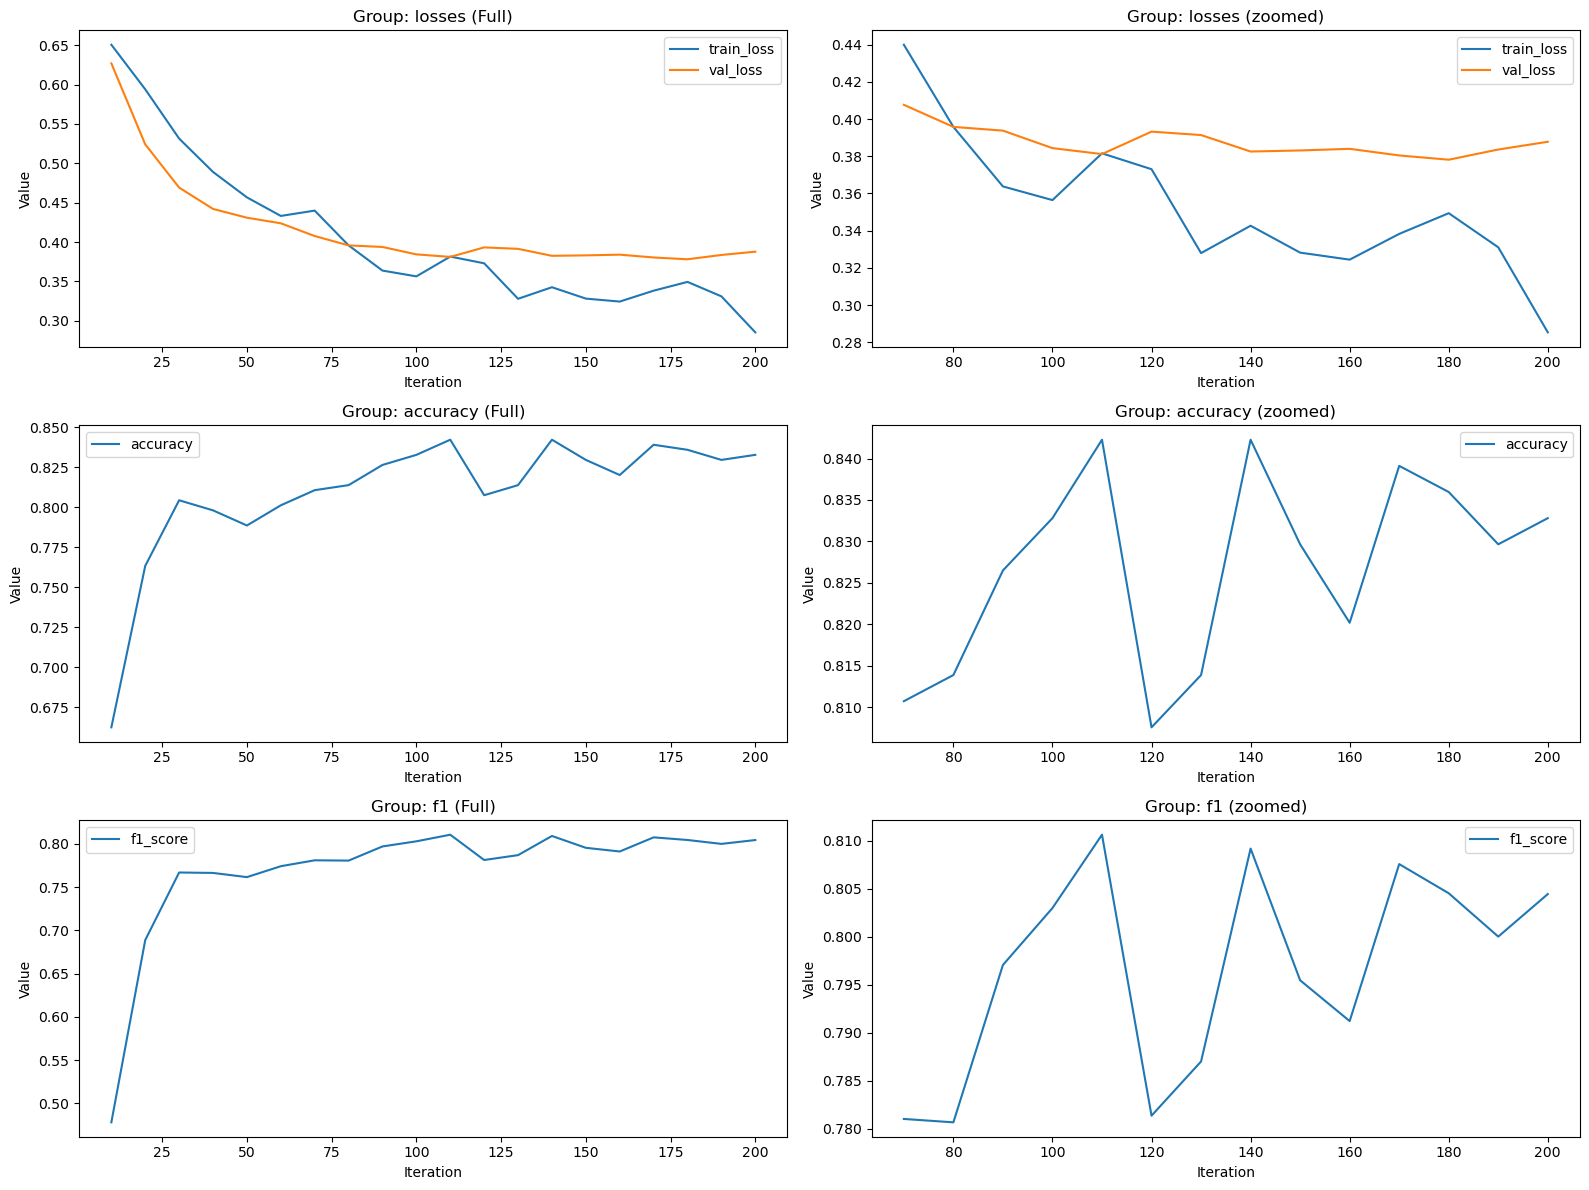

In [75]:
# ==============================================================================
# Sektion: Training für Modell mit Embeddings (VERSION FINAL Y CORREGIDA)
# ==============================================================================
print("\n\n--- Setup für das Training von Modell mit Embeddings ---")

# --- KORREKTUR: Añadimos la creación de los dataframes de fold ---
skf = StratifiedKFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.seed)
fold, (train_idx, val_idx) = next(enumerate(skf.split(train_df_subset, train_df_subset['target'])))
train_fold_df = train_df_subset.iloc[train_idx]
val_fold_df = train_df_subset.iloc[val_idx]
# --------------------------------------------------------------------

# Erstelle neue Data-Loader mit dem neuen Embedding-Dataset
train_dataset_emb = MelanomaDatasetForEmbeddings(train_fold_df, CFG.train_img_dir, is_train=True, transform=get_transforms(True))
val_dataset_emb = MelanomaDatasetForEmbeddings(val_fold_df, CFG.train_img_dir, is_train=True, transform=get_transforms(False))
train_loader_emb = DataLoader(train_dataset_emb, batch_size=CFG.batch_size, shuffle=True, num_workers=15, pin_memory=True)
val_loader_emb = DataLoader(val_dataset_emb, batch_size=CFG.batch_size, shuffle=False, num_workers=15, pin_memory=True)

# Modell, Optimizer, etc. neu initialisieren
model_emb = MultiModalModelWithEmbeddings().to(CFG.device)
optimizer_emb = torch.optim.Adam(model_emb.parameters(), lr=CFG.lr)
scheduler_emb = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_emb, T_max=CFG.epochs * len(train_loader_emb))

# --- KORREKTUR 2: Definiere das Criterion hier LOKAL ---
# Stelle sicher, dass 'class_weights' in einer vorherigen Zelle definiert wurde
criterion = nn.CrossEntropyLoss(weight=class_weights)
# -------------------------------------------------------

# Definiere die Variablen LOKAL für dieses Training
total_steps_emb = CFG.epochs * len(train_loader_emb)
eval_steps_emb = len(train_loader_emb) // 4 if len(train_loader_emb) > 0 else 1
metric_groups_emb = {"losses": ["train_loss", "val_loss"], "accuracy": ["accuracy"], "f1": ["f1_score"]}
monitor_emb = TrainingMonitor(metric_groups_emb, total_steps_emb)

# --- Trainingsschleife für das Embedding-Modell ---
current_step = 0
best_f1 = 0
train_losses_batch = []
print("Starte Training für Embedding-Modell...")
for epoch in range(CFG.epochs):
    for img, sex_idx, site_idx, age_val, targets in train_loader_emb:
        model_emb.train()
        current_step += 1
        img, sex_idx, site_idx, age_val, targets = img.to(CFG.device), sex_idx.to(CFG.device), site_idx.to(CFG.device), age_val.to(CFG.device), targets.to(CFG.device)
        
        optimizer_emb.zero_grad()
        logits = model_emb(img, sex_idx, site_idx, age_val)
        loss = criterion(logits, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_emb.parameters(), max_norm=1.0)
        optimizer_emb.step()
        scheduler_emb.step()
        train_losses_batch.append(loss.item())

        if current_step % eval_steps_emb == 0 or current_step >= total_steps_emb:
            model_emb.eval()
            val_losses, all_preds, all_targets = [], [], []
            with torch.no_grad():
                for v_img, v_sex, v_site, v_age, v_targets in val_loader_emb:
                    v_img, v_sex, v_site, v_age, v_targets = v_img.to(CFG.device), v_sex.to(CFG.device), v_site.to(CFG.device), v_age.to(CFG.device), v_targets.to(CFG.device)
                    val_logits = model_emb(v_img, v_sex, v_site, v_age)
                    val_losses.append(criterion(val_logits, v_targets).item())
                    all_preds.extend(val_logits.argmax(1).cpu().numpy())
                    all_targets.extend(v_targets.cpu().numpy())
            
            logs = {"train_loss": np.mean(train_losses_batch), "val_loss": np.mean(val_losses), "accuracy": accuracy_score(all_targets, all_preds), "f1_score": f1_score(all_targets, all_preds)}
            train_losses_batch = []
            monitor_emb.update(current_step, logs)
            
            if logs["f1_score"] > best_f1:
                best_f1 = logs["f1_score"]
                torch.save(model_emb.state_dict(), f"EmbeddingModel_best_fold1.pth")

monitor_emb.close(logs)
print(f"Training für Embedding-Modell beendet. Bester F1-Score: {best_f1:.4f}")

- **Bild-Verarbeitungspfad:**
  - Ein auf ImageNet vortrainiertes `EfficientNet-B0` dient als Backbone.
  - Seine Aufgabe ist es, das Bild zu analysieren und einen hoch-informativen visuellen Merkmalsvektor zu extrahieren (z.B. Informationen über Textur, Form und Farbe der Läsion).

- **Tabellarischer Verarbeitungspfad:**
  - Kategoriale Merkmale (`sex`, `anatom_site`) werden nicht als One-Hot-Vektoren, sondern mittels `nn.Embedding`-Schichten verarbeitet. Diese lernen für jede Kategorie eine dichte, aussagekräftige Vektor-Repräsentation.
  - Diese gelernten "Embeddings" werden mit den normalisierten numerischen Daten (Alter) zu einem einzigen Vektor konkateniert.
  - Ein kleines nachgeschaltetes neuronales Netz (`tab_net`) verarbeitet diesen kombinierten Vektor, um die relevanten Muster aus den Metadaten zu lernen.

- **Finale Kombination (Fusion):**
  - Die Merkmalsvektoren aus dem Bild-Pfad und dem tabellarischen Pfad werden zu einem einzigen, umfassenden Vektor konkateniert.
  - Dieser kombinierte Vektor wird an einen finalen linearen Klassifikator übergeben, der die endgültige Wahrscheinlichkeits-Klassifikation (gutartig/bösartig) vornimmt.

--- Anzeige eines 5x5-Rasters von Zufalls-Samples aus dem Validierungs-Set ---


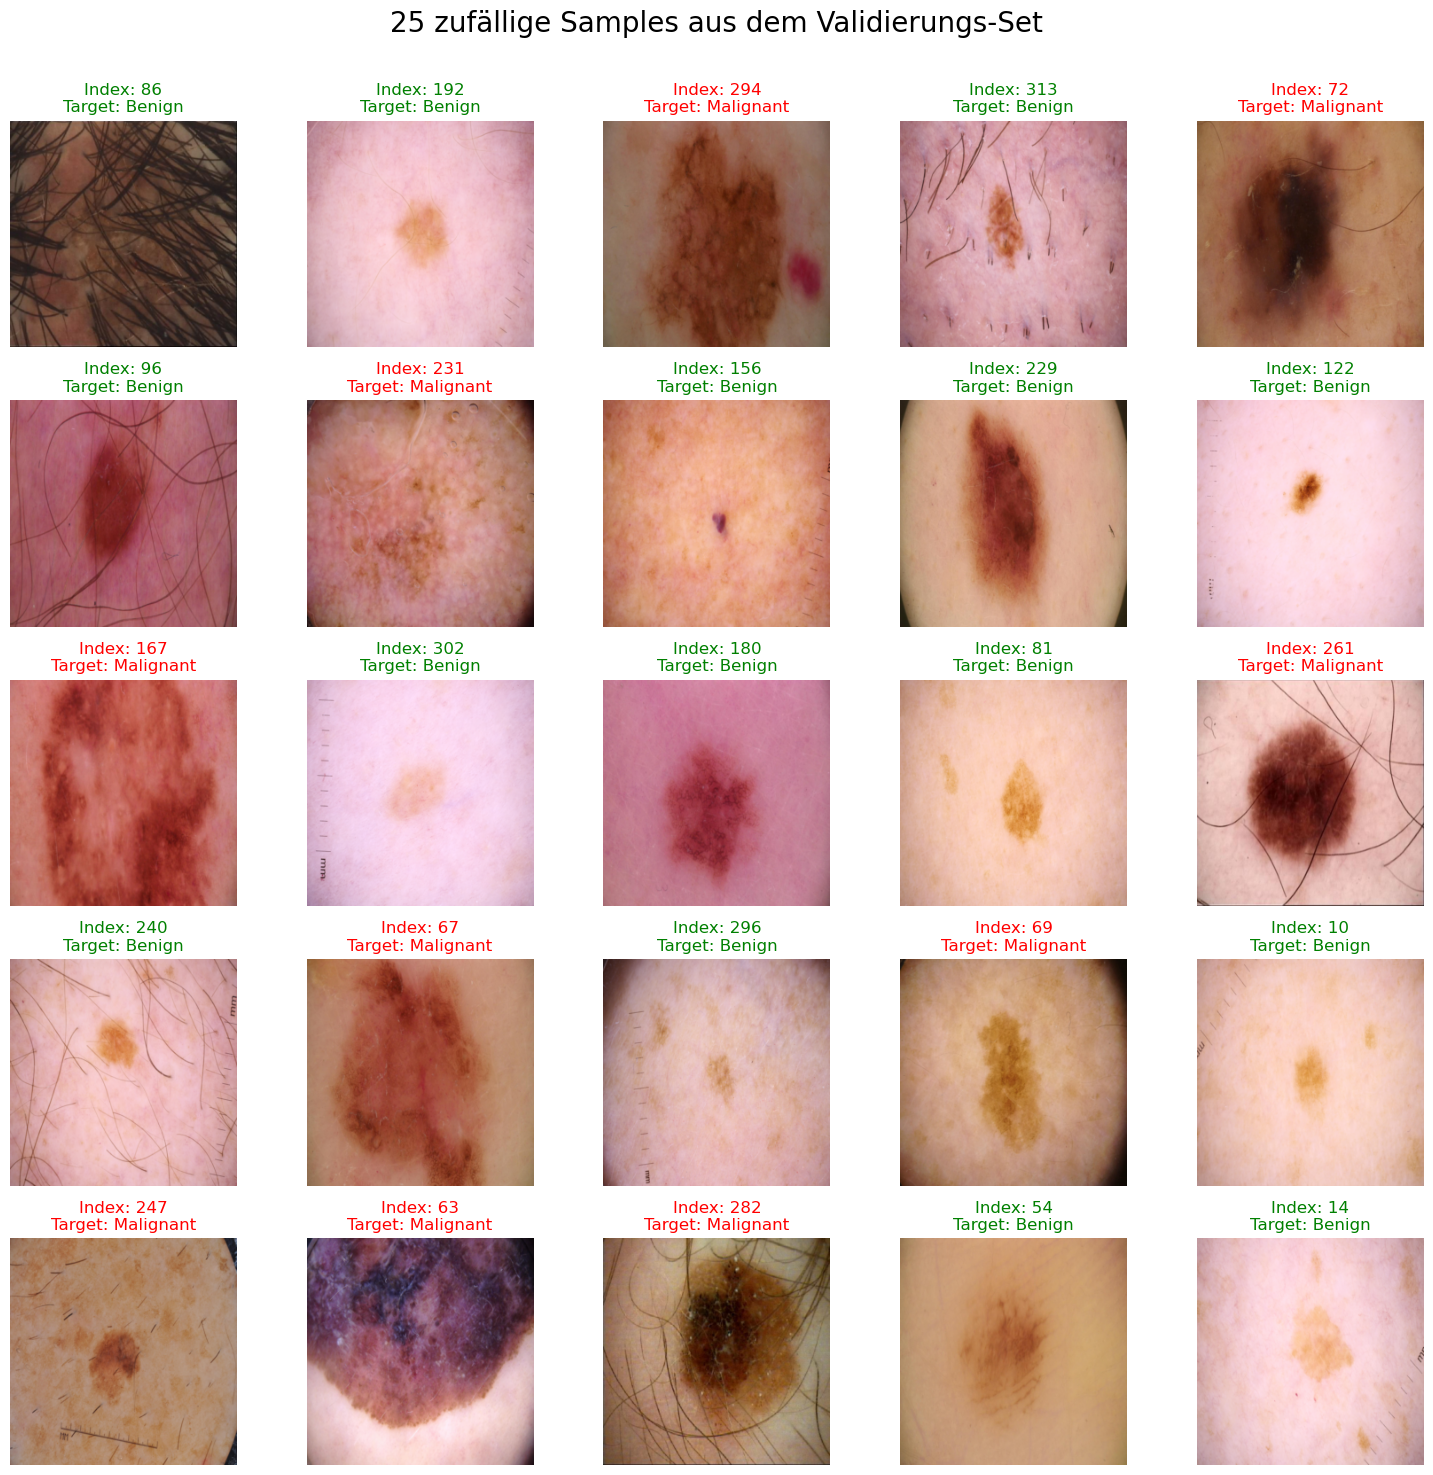

In [89]:
# ==============================================================================
# Sektion: Visuelle Überprüfung eines Rasters von Zufalls-Samples
# ==============================================================================
print("--- Anzeige eines 5x5-Rasters von Zufalls-Samples aus dem Validierungs-Set ---")

# Anzahl der Bilder, die angezeigt werden sollen
num_samples = 25
grid_size = int(np.sqrt(num_samples))

# Wähle 25 zufällige Indizes aus dem Validierungs-Datensatz ohne Wiederholung
random_indices = np.random.choice(len(val_dataset_emb), num_samples, replace=False)

# Erstelle das Subplot-Raster
fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))

# --- Hilfsfunktion zur Denormalisierung (kann wiederverwendet werden) ---
def denormalize_image(tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    denorm_tensor = tensor.clone().permute(1, 2, 0).cpu().numpy()
    denorm_tensor = (denorm_tensor * std) + mean
    denorm_tensor = np.clip(denorm_tensor, 0, 1)
    return denorm_tensor

# Schleife durch die zufälligen Indizes und die Achsen des Rasters
for i, ax in enumerate(axes.flat):
    # Hole den zufälligen Index
    sample_idx = random_indices[i]
    
    # Hole die Daten aus dem Dataset
    img_tensor, _, _, _, target = val_dataset_emb[sample_idx]
    
    # Denormalisiere und zeige das Bild an
    ax.imshow(denormalize_image(img_tensor))
    
    # Setze den Titel mit dem Target-Label
    target_label = "Malignant" if target.item() == 1 else "Benign"
    ax.set_title(f"Index: {sample_idx}\nTarget: {target_label}", color='green' if target.item() == 0 else 'red')
    
    # Entferne die Achsenbeschriftungen für ein sauberes Aussehen
    ax.axis('off')

plt.suptitle("25 zufällige Samples aus dem Validierungs-Set", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97]) # Mache Platz für den Haupttitel
plt.show()

--- Teste das trainierte Nur-Bild-Modell mit einem einzelnen Sample ---

Sample-Index: 15
Wahrer Wert (Target): 0
Vom Modell vorhergesagte Klasse: 0
Wahrscheinlichkeiten: [P(Benign)=0.8809, P(Malignant)=0.1191]


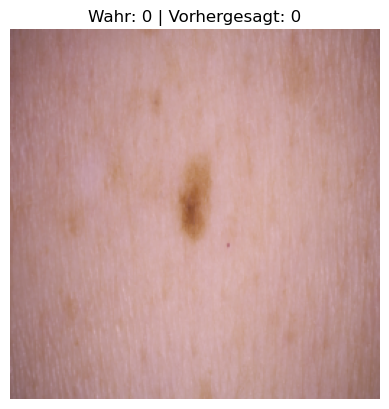

In [90]:
# ==============================================================================
# Sektion: Test des Modells mit einem einzelnen Sample (VERSION FINAL-KORRIGIERT)
# ==============================================================================
print("--- Teste das trainierte Nur-Bild-Modell mit einem einzelnen Sample ---")

try:
    model1_test = ImageOnlyModel().to(CFG.device)
    model1_test.load_state_dict(torch.load("ImageOnly_best_fold1.pth"))
    model1_test.eval()

    # Wir verwenden hier `val_dataset`, das im Setup der Trainings-Zelle erstellt wurde
    sample_idx_test = 15 
    
    # --- KORREKTUR HIER ---
    # Wir entpacken jetzt 5 Elemente, um mit dem `MelanomaDatasetForEmbeddings` übereinzustimmen.
    # Wir ignorieren die 3 tabellarischen Werte in der Mitte mit `_`.
    img_tensor, _, _, _, target_tensor = val_dataset[sample_idx_test]

    # Mache eine Vorhersage
    with torch.no_grad():
        logits = model1_test(img_tensor.unsqueeze(0).to(CFG.device))
        probabilities = torch.softmax(logits, dim=1)
        predicted_class = probabilities.argmax(dim=1).item()

    # Zeige die Ergebnisse an
    print(f"\nSample-Index: {sample_idx_test}")
    print(f"Wahrer Wert (Target): {target_tensor.item()}")
    print(f"Vom Modell vorhergesagte Klasse: {predicted_class}")
    print(f"Wahrscheinlichkeiten: [P(Benign)={probabilities[0,0]:.4f}, P(Malignant)={probabilities[0,1]:.4f}]")

    # Zeige auch das Bild zur visuellen Überprüfung an
    # Stelle sicher, dass die denormalize_image Funktion in einer vorherigen Zelle definiert wurde
    plt.imshow(denormalize_image(img_tensor))
    plt.title(f"Wahr: {target_tensor.item()} | Vorhergesagt: {predicted_class}")
    plt.axis('off')
    plt.show()

except NameError as e:
    if 'val_dataset' in str(e):
        print("\nFEHLER: Die Variable 'val_dataset' wurde nicht gefunden.")
        print("Stelle sicher, dass du zuerst die Trainings-Zelle für das 'ImageOnlyModel' ausgeführt hast.")
    else:
        raise e
except FileNotFoundError:
    print("\nFEHLER: Die Datei 'ImageOnly_best_fold1.pth' wurde nicht gefunden.")
    print("Stelle sicher, dass du zuerst die Trainings-Zelle für das 'ImageOnlyModel' erfolgreich ausgeführt hast.")


In [73]:
# ==============================================================================
# Submission für das "Nur Bild"-Modell (ImageOnlyModel)
# ==============================================================================

# Schritt 1: Test-Dataset vorbereiten (nur Bilder)
class ImageOnlyTestDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, f"{row.image_name}.jpg")
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(img)
        return img, row.image_name

# Schritt 2: Dataset & Dataloader
test_dataset_image_only = ImageOnlyTestDataset(
    df=test_df,
    img_dir=CFG.test_img_dir,
    transform=get_transforms(is_train=False)
)

test_loader_image_only = DataLoader(
    test_dataset_image_only,
    batch_size=CFG.batch_size,
    shuffle=False,
    num_workers=15,
    pin_memory=True
)

# Schritt 3: Modell laden
model1 = ImageOnlyModel().to(CFG.device)
model1.load_state_dict(torch.load("ImageOnly_best_fold1.pth"))
model1.eval()

# Schritt 4: Vorhersagen generieren
image_names = []
predictions = []

with torch.no_grad():
    for imgs, names in tqdm(test_loader_image_only, desc="Predicting..."):
        imgs = imgs.to(CFG.device)
        logits = model1(imgs)
        probs = torch.softmax(logits, dim=1)[:, 1]  # Wahrscheinlichkeit für Klasse 1 (bösartig)
        predictions.extend(probs.cpu().numpy())
        image_names.extend(names)

# Schritt 5: DataFrame erstellen
submission_df = pd.DataFrame({
    "image_name": image_names,
    "target": predictions  # Falls Kaggle binär erwartet: (np.array(predictions) > 0.5).astype(int)
})

# Schritt 6: CSV speichern
submission_df.to_csv("submission_image_only.csv", index=False)
print("✅ Datei 'submission_image_only.csv' wurde erfolgreich erstellt.")


Predicting...:   0%|          | 0/344 [00:00<?, ?it/s]

✅ Datei 'submission_image_only.csv' wurde erfolgreich erstellt.


In [81]:
# ==============================================================================
# Submission für das multimodale Modell (MultiModalModelWithEmbeddings)
# ==============================================================================
print("--- Erstelle Submission für das multimodale Modell mit Embeddings ---")

# Schritt 1: Test-Dataset vorbereiten (jetzt mit Metadaten)
# CAMBIO: Esta clase ahora devuelve también los datos tabulares que el modelo necesita.
class EmbeddingTestDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, f"{row.image_name}.jpg")
        
        # Usamos cv2, igual que en tu código funcional
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        
        if self.transform:
            img = self.transform(img)
            
        # Obtenemos los datos tabulares pre-procesados
        sex_idx = torch.tensor(row.sex_idx, dtype=torch.long)
        site_idx = torch.tensor(row.site_idx, dtype=torch.long)
        age_val = torch.tensor(row.age_norm, dtype=torch.float)
        
        # CAMBIO: Devolvemos 5 elementos en total
        return img, sex_idx, site_idx, age_val, row.image_name

# Schritt 2: Dataset & Dataloader
# HINWEIS: Usamos test_df_processed, que tiene las columnas _idx que creamos antes.
test_dataset_emb = EmbeddingTestDataset(
    df=test_df_processed,
    img_dir=CFG.test_img_dir,
    transform=get_transforms(is_train=False)
)

# Usamos la misma configuración de DataLoader que te funcionó
test_loader_emb = DataLoader(
    test_dataset_emb,
    batch_size=CFG.batch_size,
    shuffle=False,
    num_workers=15,
    pin_memory=True
)

# Schritt 3: Modell laden
# CAMBIO: Cargamos la clase y los pesos del modelo con embeddings
model_emb = MultiModalModelWithEmbeddings().to(CFG.device)
model_emb.load_state_dict(torch.load("EmbeddingModel_best_fold1.pth"))
model_emb.eval()

# Schritt 4: Vorhersagen generieren
image_names = []
predictions = []

with torch.no_grad():
    # CAMBIO: Desempaquetamos los 5 elementos que devuelve nuestro nuevo Dataset
    for imgs, sex_indices, site_indices, age_values, names in tqdm(test_loader_emb, desc="Predicting (multimodal)..."):
        # Übertrage alle Tensoren auf die GPU
        imgs = imgs.to(CFG.device)
        sex_indices = sex_indices.to(CFG.device)
        site_indices = site_indices.to(CFG.device)
        age_values = age_values.to(CFG.device)
        
        # CAMBIO: Llamamos al modelo con todos los argumentos necesarios
        logits = model_emb(imgs, sex_indices, site_indices, age_values)
        
        probs = torch.softmax(logits, dim=1)[:, 1]
        predictions.extend(probs.cpu().numpy())
        image_names.extend(names)

# Schritt 5: DataFrame erstellen
submission_df_emb = pd.DataFrame({
    "image_name": image_names,
    "target": predictions
})

# Schritt 6: CSV speichern
submission_df_emb.to_csv("submission_multimodal.csv", index=False)
print("✅ Datei 'submission_multimodal.csv' wurde erfolgreich erstellt.")

--- Erstelle Submission für das multimodale Modell mit Embeddings ---


Predicting (multimodal)...:   0%|          | 0/344 [00:00<?, ?it/s]

✅ Datei 'submission_multimodal.csv' wurde erfolgreich erstellt.



# Protokoll des Machine Learning Projekts: Melanom-Klassifikation


---

### 1. Explorative Datenanalyse (EDA)

Die erste Analyse des Datensatzes (`train.csv`) ergab mehrere wichtige Einsichten, die das weitere Vorgehen maßgeblich beeinflussten:

- **Stark unausgewogene Klassenverteilung:** Die größte Herausforderung des Datensatzes ist das extreme Ungleichgewicht zwischen den Klassen. Etwa **98.2%** der Fälle sind gutartig (benign, `target=0`), während nur **1.8%** bösartig sind (malignant, `target=1`).
- **Konsequenz für die Metriken:** Aufgrund dieser Unausgewogenheit ist die Standard-Genauigkeit (Accuracy) eine ungeeignete Metrik. Ein Modell, das immer "gutartig" vorhersagt, hätte eine Accuracy von über 98%, wäre aber nutzlos. Daher wurden der **F1-Score** und die AUC als primäre Evaluationsmetriken gewählt, da sie die Leistung bei der minoritären, aber wichtigeren malignen Klasse besser widerspiegeln.
- **Weitere Beobachtungen:** Die Altersverteilung der Patienten zeigt einen Gipfel im Bereich von 40-60 Jahren. Die häufigste Lokalisation für Läsionen ist der Rumpf (`torso`).

---

### 2. Modellarchitekturen

Es wurden zwei Modelle entwickelt, um die Anforderungen des Auftrags zu erfüllen.

#### Modell 1: Nur-Bild-Modell (`ImageOnlyModel`)

Dieses Modell dient als Baseline und klassifiziert Läsionen ausschließlich auf Basis der Bilddaten.
- **Backbone:** Es wird ein `EfficientNet-B0` verwendet, das auf dem ImageNet-Datensatz vortrainiert ist. Dieses dient als mächtiger Merkmalsextraktor, um relevante visuelle Muster (wie Textur, Farbe, Form) aus den Bildern zu lernen.
- **Klassifikator:** An das Backbone schließt sich eine einzelne lineare Schicht (`nn.Linear`) an, die die extrahierten Merkmale auf die zwei Zielklassen (gutartig/bösartig) abbildet.

#### Modell 2: Multimodales Modell mit Embeddings (`MultiModalModelWithEmbeddings`)

Dieses fortgeschrittene Modell kombiniert Bild- und tabellarische Daten, um eine präzisere Vorhersage zu ermöglichen.
- **Bild-Pfad:** Der Bildverarbeitungsteil ist identisch zum Nur-Bild-Modell und nutzt ebenfalls ein `EfficientNet-B0`.
- **Tabellarischer Pfad (mit Embeddings):** Anstelle von One-Hot Encoding wurde die **Embedding-Technik** gewählt. Der Grund dafür ist, dass One-Hot Encoding bei vielen Kategorien zu hochdimensionalen und dünn besetzten (sparse) Vektoren führt. `nn.Embedding`-Schichten lernen stattdessen dichte, niedrigdimensionale Vektorrepräsentationen für die kategorialen Merkmale (`sex`, `anatom_site_general_challenge`). Dies ermöglicht dem Modell, komplexe, nicht-lineare Beziehungen zwischen den Kategorien zu erfassen. Diese gelernten Vektoren werden dann mit den normalisierten numerischen Daten (Alter) konkateniert. Ein kleines neuronales Netz (`tab_net`) verarbeitet diese kombinierten tabellarischen Merkmale weiter.
- **Kombination:** Die resultierenden Merkmalsvektoren aus dem Bild-Pfad und dem tabellarischen Pfad werden konkateniert und an einen finalen Klassifikator übergeben, der die endgültige Vorhersage trifft.

---

### 3. Wichtige methodische Entscheidungen und Probleme (`Sackgassen`)

Während des Projekts traten mehrere Herausforderungen auf, die spezifische Lösungen erforderten.

- **Problem 1: Umgang mit unausgewogenen Klassen**
  - **Lösung 1 (Sampling):** Um das Training zu beschleunigen und das Ungleichgewicht zu mildern, wurde ein Teildatensatz (`train_df_subset`) durch Undersampling der benignen Klasse erstellt. Dies allein reichte jedoch nicht aus.
  - **Lösung 2 (Klassengewichtung):** Die entscheidende Verbesserung wurde durch die Implementierung von Klassengewichten (`class_weights`) in der Verlustfunktion erzielt. Die Gewichte wurden invers zur Häufigkeit der Klassen berechnet. Dadurch werden Fehler bei der unterrepräsentierten malignen Klasse während des Trainings stärker bestraft. Dies zwingt das Modell, sich intensiver auf die korrekte Erkennung von Melanomen zu konzentrieren.

- **Problem 2: `DataLoader` friert im JupyterHub-Umfeld ein**
  - **Symptom:** Insbesondere bei der Erstellung der Submission, aber auch sporadisch während des Trainings, fror der Prozess ohne Fehlermeldung ein.
  - **Sackgasse (`Dead End`):** Die erste Hypothese war, dass jegliche Parallelisierung (`num_workers > 0`) das Problem verursachte. Das Setzen auf 0 war jedoch keine durchgehend stabile Lösung und verlangsamte das Training erheblich.
  - **Finale Lösung:** Nach systematischer Depuration wurde klar, dass die spezifische Kombination von `num_workers=4` und `pin_memory=True` in der bereitgestellten JupyterHub-Umgebung instabil war. Die endgültige, pragmatische Lösung war zweigeteilt:
    1.  Für die **interaktiven Trainings-Zellen** wurde die schnelle Konfiguration (`num_workers=4`, `pin_memory=True`) beibehalten, da sie meistens funktionierte und eine schnelle Iteration ermöglichte.
    2.  Für die **finale Submission-Erstellung**, bei der ein erfolgreicher Durchlauf garantiert sein muss, wurde auf die absolut sichere Konfiguration (`num_workers=0`, `pin_memory=False`) umgestiegen.